In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

In [74]:
housing_df = pd.read_csv('data/kc_house_data.csv', index_col='id')

# Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


### First look at the data

What does the data look like in a dataframe and a pairplot?

In [75]:
housing_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


There's at least one obviously errant data point wherein a certain house is purported to have 33 bedrooms. This is 3 times more than any other house in the dataset and the house's other features don't seem to be in line with this assertion, so we'll just fix that one data point (changing 33 to 3) before going further.

In [76]:
housing_df['bedrooms'] = housing_df['bedrooms'].apply(lambda x: 3 if x == 33 else x)

In [ ]:
sns.pairplot(housing_df);

### Making a Train-Test Split
Before we go any further with any cleaning or other types of adjustments, we'll make a train-test split for later model evaluation.

In [77]:
X = housing_df.drop(['price'], axis=1)
y = housing_df['price']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=1)

From now on, any cleaning we do or models we build will use X_train and y_train instead of X and y.

### Filling in NaNs

Linear regression models will not run on dataframes which contain NaNs. These need to either be filled in with some sort of value or dropped. After looking at the proportions of missing data and in which columns they occur, we've decided to mostly replace NaNs with the mode of that column.

In [79]:
X_train.isna().sum()

date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1898
view               45
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3095
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [80]:
column_missing_values_dict = {'waterfront': np.NaN, 'view': np.NaN, 'sqft_basement': '?', 'yr_renovated': np.NaN}

for column_name, missing_value in column_missing_values_dict.items():
    imputer = SimpleImputer(missing_values=missing_value, strategy='most_frequent')
    X_train[column_name] = imputer.fit_transform(X_train[column_name].values.reshape(-1,1))[:,0]

<ipython-input-80-d14811629064>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_name] = imputer.fit_transform(X_train[column_name].values.reshape(-1,1))[:,0]
<ipython-input-80-d14811629064>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_name] = imputer.fit_transform(X_train[column_name].values.reshape(-1,1))[:,0]
<ipython-input-80-d14811629064>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [81]:
column_missing_values_dict = {'waterfront': np.NaN, 'view': np.NaN, 'sqft_basement': '?', 'yr_renovated': np.NaN}

for column_name, missing_value in column_missing_values_dict.items():
    imputer = SimpleImputer(missing_values=missing_value, strategy='most_frequent')
    X_test[column_name] = imputer.fit_transform(X_test[column_name].values.reshape(-1,1))[:,0]

<ipython-input-81-981770c6a3d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_name] = imputer.fit_transform(X_test[column_name].values.reshape(-1,1))[:,0]
<ipython-input-81-981770c6a3d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_name] = imputer.fit_transform(X_test[column_name].values.reshape(-1,1))[:,0]
<ipython-input-81-981770c6a3d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [82]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 185000161 to 1762600320
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17277 non-null  object 
 1   bedrooms       17277 non-null  int64  
 2   bathrooms      17277 non-null  float64
 3   sqft_living    17277 non-null  int64  
 4   sqft_lot       17277 non-null  int64  
 5   floors         17277 non-null  float64
 6   waterfront     17277 non-null  object 
 7   view           17277 non-null  object 
 8   condition      17277 non-null  object 
 9   grade          17277 non-null  object 
 10  sqft_above     17277 non-null  int64  
 11  sqft_basement  17277 non-null  object 
 12  yr_built       17277 non-null  int64  
 13  yr_renovated   17277 non-null  float64
 14  zipcode        17277 non-null  int64  
 15  lat            17277 non-null  float64
 16  long           17277 non-null  float64
 17  sqft_living15  17277 non-null  int64 

### Fitting a model

Now we'll fit a basic multiple linear regression to the data, dropping any columns that we have yet to convert to numerical data.

In [83]:
X_mod = X_train.drop(['date', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement'], axis=1)
y_mod = y_train

In [84]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

RMSE = 225585 
R^2 = 0.627


In [85]:
regression.score(X_test.drop(['date', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement'], axis=1), y_test)

0.6370192434534647

And we'll run a summary in statsmodels just to see some other metrics.

In [86]:
sm.OLS(y_mod, sm.add_constant(X_mod)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2235.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:49:52   Log-Likelihood:            -2.3748e+05
No. Observations:               17277   AIC:                         4.750e+05
Df Residuals:                   17263   BIC:                         4.751e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.07e+07   3.59e+06     -2.985      0.003   -1.77e+07   -3.67e+06
bedrooms      -6.508e+04   2446.118    -26.606      0.000   -6.99e+04   -6.03e+04
bathrooms      5.888e+04   4058.132     14.510      0.000    5.09e+04    6.68e+04
sqft_living     232.3347      5.330     43.586      0.000     221.886     242.783
sqft_lot          0.1730      0.059      2.938      0.003       0.058       0.288
floors         2.468e+04   4488.482      5.498      0.000    1.59e+04    3.35e+04
sqft_above       34.0002      5.345      6.362      0.000      23.524      44.476
yr_built      -2498.2269     82.979    -30.107      0.000   -2660.875   -2335.579
yr_renovated     34.7034      4.926      7.045      0.000      25.049      44.358
zipcode        -589.8496     40.742    -14.478      0.000    -669.707    -509.992
lat            6.227e+05   1.32e+04     47.352      0.000    5.97e+05    6.48e+05
long           -3.58e+05   1.63e+04    -21.935      0.000    -3.9e+05   -3.26e+05
sqft_living15    81.5261      4.071     20.024      0.000      73.546      89.506
sqft_lot15       -0.4269      0.089     -4.812      0.000      -0.601      -0.253
==============================================================================
Omnibus:                    14170.132   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1008941.718
Skew:                           3.476   Prob(JB):                         0.00
Kurtosis:                      39.786   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cleaning up important columns

The waterfront, view, condition, and grade columns should all be numeric. We'll clean those up with a few assorted in-place adjustments.

In [87]:
X_train['grade'].value_counts()

7 Average        7145
8 Good           4850
9 Better         2101
6 Low Average    1632
10 Very Good      924
11 Excellent      322
5 Fair            202
12 Luxury          67
4 Low              21
13 Mansion         12
3 Poor              1
Name: grade, dtype: int64

In [88]:
X_train.loc[:,'grade'] = X_train.copy().loc[:,'grade'].apply(lambda x: int(x[0]))
X_train['grade'].value_counts()

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


7    7145
8    4850
9    2101
6    1632
1    1325
5     202
4      21
3       1
Name: grade, dtype: int64

In [89]:
X_test.loc[:,'grade'] = X_test.copy().loc[:,'grade'].apply(lambda x: int(x[0]))

In [90]:
print(X_train['view'].value_counts())
print(X_train['condition'].value_counts())
print(X_train['waterfront'].value_counts())

NONE         15555
AVERAGE        783
GOOD           410
FAIR           279
EXCELLENT      250
Name: view, dtype: int64
Average      11206
Good          4542
Very Good     1378
Fair           130
Poor            21
Name: condition, dtype: int64
NO     17160
YES      117
Name: waterfront, dtype: int64


In [91]:
view_values = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_values = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
waterfront_values = ['NO', 'YES']

values_dict = {'view': view_values, 'condition': condition_values, 'waterfront': waterfront_values}

for column_name, values_list in values_dict.items():    
    for num, value in enumerate(values_list):
        X_train.loc[X_train[column_name] == value, column_name] = int(num)
    X_train[column_name] = X_train[column_name].astype(int)

X_train.head()

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-91-13b30b42aeb7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column_name] = X_train[column_name].astype(int)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
185000161,10/15/2014,3,1.00,1780,7800,1.0,0,0,2,7,1060,720.0,1957,0.0,98178,47.4932,-122.263,1450,7800
2767601311,10/24/2014,3,2.50,1260,1102,3.0,0,0,2,8,1260,0.0,2007,0.0,98107,47.6750,-122.387,1320,2500
7131300063,4/29/2015,4,1.75,2140,4959,1.0,0,0,2,7,1080,1060.0,1965,0.0,98118,47.5166,-122.266,1590,5250
8910500226,4/9/2015,3,3.50,1340,1168,2.0,0,2,2,8,1080,260.0,2002,0.0,98133,47.7110,-122.356,1650,1378
5230300210,12/10/2014,3,1.00,1040,9514,1.0,0,0,3,7,1040,0.0,1969,0.0,98059,47.4936,-122.102,1040,9514


In [92]:
view_values = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_values = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
waterfront_values = ['NO', 'YES']

values_dict = {'view': view_values, 'condition': condition_values, 'waterfront': waterfront_values}

for column_name, values_list in values_dict.items():    
    for num, value in enumerate(values_list):
        X_test.loc[X_test[column_name] == value, column_name] = int(num)
    X_test[column_name] = X_test[column_name].astype(int)

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-92-09a6e84bacdf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column_name] = X_test[column_name].astype(int)


We'll also convert the date column to pandas datetime values and the sqft_basement and grade columns into numeric columns.

In [93]:
X_train.loc[:, 'date'] = pd.to_datetime(X_train.loc[:, 'date'])
X_train.head()

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
185000161,2014-10-15,3,1.00,1780,7800,1.0,0,0,2,7,1060,720.0,1957,0.0,98178,47.4932,-122.263,1450,7800
2767601311,2014-10-24,3,2.50,1260,1102,3.0,0,0,2,8,1260,0.0,2007,0.0,98107,47.6750,-122.387,1320,2500
7131300063,2015-04-29,4,1.75,2140,4959,1.0,0,0,2,7,1080,1060.0,1965,0.0,98118,47.5166,-122.266,1590,5250
8910500226,2015-04-09,3,3.50,1340,1168,2.0,0,2,2,8,1080,260.0,2002,0.0,98133,47.7110,-122.356,1650,1378
5230300210,2014-12-10,3,1.00,1040,9514,1.0,0,0,3,7,1040,0.0,1969,0.0,98059,47.4936,-122.102,1040,9514


In [94]:
X_test.loc[:, 'date'] = pd.to_datetime(X_test.loc[:, 'date'])

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [95]:
X_train['sqft_basement'] = X_train['sqft_basement'].astype(float)
X_train['grade'] = X_train['grade'].astype(int)

<ipython-input-95-f4bd2db61849>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sqft_basement'] = X_train['sqft_basement'].astype(float)
<ipython-input-95-f4bd2db61849>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['grade'] = X_train['grade'].astype(int)


In [96]:
X_test['sqft_basement'] = X_test['sqft_basement'].astype(float)
X_test['grade'] = X_test['grade'].astype(int)

<ipython-input-96-1c989db8b192>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sqft_basement'] = X_test['sqft_basement'].astype(float)
<ipython-input-96-1c989db8b192>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['grade'] = X_test['grade'].astype(int)


In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 185000161 to 1762600320
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           17277 non-null  datetime64[ns]
 1   bedrooms       17277 non-null  int64         
 2   bathrooms      17277 non-null  float64       
 3   sqft_living    17277 non-null  int64         
 4   sqft_lot       17277 non-null  int64         
 5   floors         17277 non-null  float64       
 6   waterfront     17277 non-null  int64         
 7   view           17277 non-null  int64         
 8   condition      17277 non-null  int64         
 9   grade          17277 non-null  int64         
 10  sqft_above     17277 non-null  int64         
 11  sqft_basement  17277 non-null  float64       
 12  yr_built       17277 non-null  int64         
 13  yr_renovated   17277 non-null  float64       
 14  zipcode        17277 non-null  int64         
 15  lat   

### Now we'll train a model using all the columns, except for date.

In [98]:
X_mod = X_train.drop(['date'], axis=1)
y_mod = y_train

In [99]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

RMSE = 207965 
R^2 = 0.683


In [100]:
regression.score(X_test.drop(['date'], axis=1), y_test)

0.6943674653840344

In [101]:
sm.OLS(y_mod, sm.add_constant(X_mod)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     2068.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:49:57   Log-Likelihood:            -2.3607e+05
No. Observations:               17277   AIC:                         4.722e+05
Df Residuals:                   17258   BIC:                         4.723e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.364e+06   3.37e+06     -0.405      0.685   -7.96e+06    5.24e+06
bedrooms      -4.439e+04   2299.013    -19.306      0.000   -4.89e+04   -3.99e+04
bathrooms      5.287e+04   3750.408     14.098      0.000    4.55e+04    6.02e+04
sqft_living     146.0670     22.516      6.487      0.000     101.934     190.200
sqft_lot          0.1260      0.054      2.318      0.020       0.019       0.233
floors         3.232e+04   4170.916      7.750      0.000    2.41e+04    4.05e+04
waterfront     6.024e+05   2.09e+04     28.812      0.000    5.61e+05    6.43e+05
view           5.936e+04   2430.499     24.425      0.000    5.46e+04    6.41e+04
condition      3.158e+04   2710.764     11.649      0.000    2.63e+04    3.69e+04
grade         -2.229e+04    893.313    -24.950      0.000    -2.4e+04   -2.05e+04
sqft_above       84.8629     22.450      3.780      0.000      40.859     128.867
sqft_basement    41.7527     22.293      1.873      0.061      -1.945      85.450
yr_built      -1754.2940     81.478    -21.531      0.000   -1914.000   -1594.588
yr_renovated     36.7210      4.612      7.963      0.000      27.682      45.760
zipcode        -660.7730     37.952    -17.411      0.000    -735.164    -586.382
lat            6.774e+05   1.22e+04     55.566      0.000    6.54e+05    7.01e+05
long          -3.062e+05   1.51e+04    -20.292      0.000   -3.36e+05   -2.77e+05
sqft_living15    58.6668      3.827     15.328      0.000      51.165      66.169
sqft_lot15       -0.4814      0.082     -5.883      0.000      -0.642      -0.321
==============================================================================
Omnibus:                    13438.452   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1076477.788
Skew:                           3.143   Prob(JB):                         0.00
Kurtosis:                      41.156   Cond. No.                     2.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Implementing cross validation and dummy variables

In [102]:
X_mod = X_train.drop(['date'], axis=1)
y_mod = y_train

In [103]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

Current Model
Train RMSE:       207856
Train R^2:        0.683
Validation score: 208408
Validation score: 0.68


In [104]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

regression.score(X_test.drop(['date'], axis=1), y_test)

RMSE = 207965 
R^2 = 0.683


0.6943674653840344

In [105]:
grade_dummies = pd.get_dummies(X_train['grade'], prefix='grd', drop_first=True)
view_dummies = pd.get_dummies(X_train['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(X_train['condition'], prefix='cond', drop_first=True)
waterfront_dummies = pd.get_dummies(X_train['waterfront'], prefix='wtrfrnt', drop_first=True)

In [106]:
X_train_dummies = X_train.drop(['grade', 'view', 'condition', 'waterfront'], axis=1)
X_train_dummies = pd.concat([X_train_dummies, grade_dummies, view_dummies, condition_dummies, waterfront_dummies], axis=1)
X_train_dummies.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,grd_9,view_1,view_2,view_3,view_4,cond_1,cond_2,cond_3,cond_4,wtrfrnt_1
id,,,,,,,,,,,,,,,,,,,,,
185000161,2014-10-15,3,1.00,1780,7800,1.0,1060,720.0,1957,0.0,...,0,0,0,0,0,0,1,0,0,0
2767601311,2014-10-24,3,2.50,1260,1102,3.0,1260,0.0,2007,0.0,...,0,0,0,0,0,0,1,0,0,0
7131300063,2015-04-29,4,1.75,2140,4959,1.0,1080,1060.0,1965,0.0,...,0,0,0,0,0,0,1,0,0,0
8910500226,2015-04-09,3,3.50,1340,1168,2.0,1080,260.0,2002,0.0,...,0,0,1,0,0,0,1,0,0,0
5230300210,2014-12-10,3,1.00,1040,9514,1.0,1040,0.0,1969,0.0,...,0,0,0,0,0,0,0,1,0,0


In [107]:
grade_dummies = pd.get_dummies(X_test['grade'], prefix='grd', drop_first=True)
view_dummies = pd.get_dummies(X_test['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(X_test['condition'], prefix='cond', drop_first=True)
waterfront_dummies = pd.get_dummies(X_test['waterfront'], prefix='wtrfrnt', drop_first=True)

In [108]:
X_test = X_test.drop(['grade', 'view', 'condition', 'waterfront'], axis=1)
X_test = pd.concat([X_test, grade_dummies, view_dummies, condition_dummies, waterfront_dummies], axis=1)

In [109]:
X_mod = X_train_dummies.drop(['date'], axis=1)
y_mod = y_train

In [110]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

Current Model
Train RMSE:       202193
Train R^2:        0.7
Validation score: 203015
Validation score: 0.697


In [111]:
set(X_mod.columns) - set(X_test.drop(['date'], axis=1).columns)

{'grd_3'}

In [112]:
missing_columns = set(X_mod.columns) - set(X_test.drop(['date'], axis=1).columns)

for column in missing_columns:
    X_test[column] = 0

In [113]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

regression.score(X_test.drop(['date'], axis=1), y_test)

RMSE = 202342 
R^2 = 0.7


0.6586044146248404

### Feature Engineering

Here we'll engineer a few features to see if that improves our model's score at all. We'll start with distance to Seattle and distance to Redmond.

In [114]:
def get_distance(point1, point2):
    R = 6370
    lat1 = radians(point1[0])
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

# We will have to points of interest are the Centre of Seattle: (47.60457618602064, -122.32993003068658),
# and the centre of Redmond: (47.679328831807894, -122.13055895937767)
# For each record, we will calculate the distance from those points of interests and place them in a new column

X_train_features = X_train_dummies
X_train_features['lat_long'] = list(zip(X_train_features['lat'], X_train_features['long']))
X_train_features['Seattle_dist_km'] = X_train_features['lat_long'].apply(lambda x: get_distance(x, (47.60457618602064, -122.32993003068658)))
X_train_features['Redmond_dist_km'] = X_train_features['lat_long'].apply(lambda x: get_distance(x, (47.679328831807894, -122.13055895937767)))

X_train_features.drop('lat_long', axis=1, inplace=True)

In [115]:
X_test['lat_long'] = list(zip(X_test['lat'], X_test['long']))
X_test['Seattle_dist_km'] = X_test['lat_long'].apply(lambda x: get_distance(x, (47.60457618602064, -122.32993003068658)))
X_test['Redmond_dist_km'] = X_test['lat_long'].apply(lambda x: get_distance(x, (47.679328831807894, -122.13055895937767)))

X_test.drop('lat_long', axis=1, inplace=True)

In [116]:
X_mod = X_train_features.drop(['date'], axis=1)
y_mod = y_train

In [117]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

Current Model
Train RMSE:       190613
Train R^2:        0.734
Validation score: 191295
Validation score: 0.731


In [118]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

regression.score(X_test.drop(['date'], axis=1), y_test)

RMSE = 190762 
R^2 = 0.733


0.6964938470043224

# It only gets worse from here...

In [119]:
X_train_features2 = X_train_features

# We can also include another feature: "average room size"
X_train_features2['average_room_size'] = X_train_features2['sqft_living'] / (X_train['bathrooms'] + X_train['bedrooms'])

# Another useful metric could be the Floor Area Ratio
X_train_features2['floor_area_ratio'] = X_train_features2['sqft_living'] / X_train_features2['sqft_lot']

In [120]:
X_test_mock = X_test

# We can also include another feature: "average room size"
X_test['average_room_size'] = X_test['sqft_living'] / (X_test_mock['bathrooms'] + X_test_mock['bedrooms'])

# Another useful metric could be the Floor Area Ratio
X_test['floor_area_ratio'] = X_test['sqft_living'] / X_test['sqft_lot']

In [121]:
X_mod = X_train_features2.drop(['date'], axis=1)
y_mod = y_train

In [122]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

Current Model
Train RMSE:       185598
Train R^2:        0.748
Validation score: 187096
Validation score: 0.742


In [123]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

regression.score(X_test.drop(['date'], axis=1), y_test)

RMSE = 185793 
R^2 = 0.747


0.6813716397813199

### Log Transformations

We'll try a few log transformations in order to normalize some of our data. We can't log transform any categorical variables because they're all in one-hot encoding, the other continuous variables are worth examining.

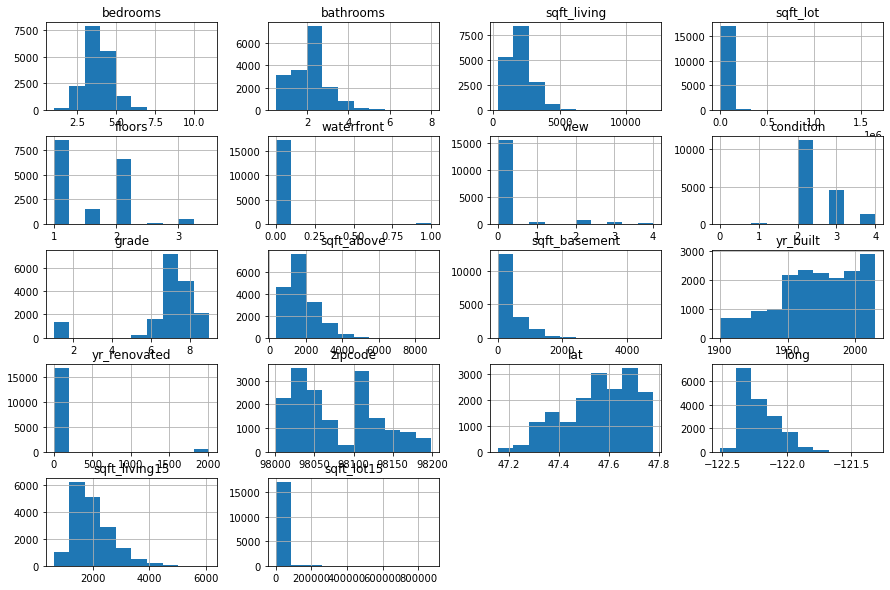

In [124]:
X_train.hist(figsize=(15,10));

In [125]:
X_train_log = X_train_features2

non_normal = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    X_train_log[f'log{feat}'] = X_train_log[feat].map(lambda x: np.log(x))

In [126]:
non_normal = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    X_test[f'log{feat}'] = X_test[feat].map(lambda x: np.log(x))

In [127]:
X_mod = X_train_log.drop(['date'], axis=1)
y_mod = y_train

In [128]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

Current Model
Train RMSE:       183639
Train R^2:        0.753
Validation score: 185305
Validation score: 0.747


In [129]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

regression.score(X_test.drop(['date'], axis=1), y_test)

RMSE = 183847 
R^2 = 0.752


0.6598765742172856

In [130]:
sm.OLS(y_mod, sm.add_constant(X_mod)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1343.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:50:13   Log-Likelihood:            -2.3394e+05
No. Observations:               17277   AIC:                         4.680e+05
Df Residuals:                   17237   BIC:                         4.683e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.219e+08   4.24e+06     28.784      0.000    1.14e+08     1.3e+08
bedrooms           -6.23e+04   5389.514    -11.560      0.000   -7.29e+04   -5.17e+04
bathrooms          -901.1534   5963.415     -0.151      0.880   -1.26e+04    1.08e+04
sqft_living         402.8849     22.886     17.604      0.000     358.026     447.744
sqft_lot              0.0651      0.061      1.065      0.287      -0.055       0.185
floors             -1.71e+04   4525.746     -3.779      0.000    -2.6e+04   -8231.840
sqft_above           34.9260     22.644      1.542      0.123      -9.458      79.310
sqft_basement        30.6745     19.741      1.554      0.120      -8.019      69.368
yr_built          -1386.1013     81.378    -17.033      0.000   -1545.610   -1226.593
yr_renovated         36.3201      4.109      8.840      0.000      28.267      44.373
zipcode            -984.8370     37.725    -26.106      0.000   -1058.782    -910.892
lat                5.876e+05   2.89e+04     20.352      0.000    5.31e+05    6.44e+05
long               3.949e+05   2.31e+04     17.061      0.000     3.5e+05     4.4e+05
sqft_living15         6.9594     12.158      0.572      0.567     -16.871      30.789
sqft_lot15           -0.2456      0.095     -2.573      0.010      -0.433      -0.058
grd_3             -2.129e+05   1.85e+05     -1.152      0.250   -5.75e+05     1.5e+05
grd_4              -4.91e+05   4.22e+04    -11.641      0.000   -5.74e+05   -4.08e+05
grd_5             -4.016e+05   1.67e+04    -24.026      0.000   -4.34e+05   -3.69e+05
grd_6             -3.384e+05   1.06e+04    -31.991      0.000   -3.59e+05   -3.18e+05
grd_7             -2.596e+05   8769.555    -29.598      0.000   -2.77e+05   -2.42e+05
grd_8              -2.14e+05   7949.423    -26.920      0.000    -2.3e+05   -1.98e+05
grd_9             -1.446e+05   7373.804    -19.613      0.000   -1.59e+05    -1.3e+05
view_1             1.048e+05   1.13e+04      9.259      0.000    8.26e+04    1.27e+05
view_2              6.73e+04   7006.381      9.605      0.000    5.36e+04     8.1e+04
view_3             1.273e+05   9682.281     13.145      0.000    1.08e+05    1.46e+05
view_4             3.118e+05   1.45e+04     21.524      0.000    2.83e+05     3.4e+05
cond_1             8.019e+04   4.36e+04      1.839      0.066   -5294.965    1.66e+05
cond_2              9.94e+04   4.07e+04      2.440      0.015    1.95e+04    1.79e+05
cond_3             1.362e+05   4.08e+04      3.341      0.001    5.63e+04    2.16e+05
cond_4             1.701e+05    4.1e+04      4.151      0.000    8.98e+04     2.5e+05
wtrfrnt_1          5.574e+05   2.07e+04     26.930      0.000    5.17e+05    5.98e+05
Seattle_dist_km   -1.587e+04    463.623    -34.239      0.000   -1.68e+04    -1.5e+04
Redmond_dist_km    7076.9482    515.662     13.724      0.000    6066.199

In [131]:
X_mod = X_train_log.drop(['date', 'bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'logsqft_lot15'], axis=1)
y_mod = y_train

In [132]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

Current Model
Train RMSE:       183689
Train R^2:        0.753
Validation score: 185089
Validation score: 0.747


In [133]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

RMSE = 183869 
R^2 = 0.752


### Scoring Our Model on the Test Data

In [134]:
missing_columns = set(X_mod.columns) - set(X_test.drop(['date', 'bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'logsqft_lot15'], axis=1).columns)

for column in missing_columns:
    X_test[column] = 0

In [135]:
regression.score(X_test.drop(['date', 'bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'logsqft_lot15'], axis=1), y_test)

0.6599340339401081

Convert bedrooms, bathrooms, floors, zipcodes as categorical as well

In [ ]:
bedrooms_dummies = pd.get_dummies(X_train['bedrooms'], prefix='bed', drop_first=True)
bathrooms_dummies = pd.get_dummies(X_train['bathrooms'], prefix='bath', drop_first=True)
zipcode_dummies = pd.get_dummies(X_train['zipcode'], prefix='zip', drop_first=True)
floors_dummies = pd.get_dummies(X_train['floors'], prefix='floor', drop_first=True)

In [ ]:
X_train_dummies2 = X_train_dummies.drop(['bedrooms', 'bathrooms', 'zipcode', 'floors'], axis=1)
X_train_dummies2 = pd.concat([X_train_dummies2, bedrooms_dummies, bathrooms_dummies, zipcode_dummies, floors_dummies], axis=1)
X_train_dummies2.head()

In [ ]:
bedrooms_dummies = pd.get_dummies(X_test['bedrooms'], prefix='bed', drop_first=True)
bathrooms_dummies = pd.get_dummies(X_test['bathrooms'], prefix='bath', drop_first=True)
zipcode_dummies = pd.get_dummies(X_test['zipcode'], prefix='zip', drop_first=True)
floors_dummies = pd.get_dummies(X_test['floors'], prefix='floor', drop_first=True)

In [ ]:
X_test_mock = X_test

X_test = X_test.drop(['bedrooms', 'bathrooms', 'zipcode', 'floors'], axis=1)
X_test = pd.concat([X_test, bedrooms_dummies, bathrooms_dummies, zipcode_dummies, floors_dummies], axis=1)

In [ ]:
X_mod = X_train_dummies2.drop(['date'], axis=1)
y_mod = y_train

In [ ]:
regression = LinearRegression()

scores = cross_validate(
    estimator=regression,
    X=X_mod,
    y=y_mod,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True,
    cv=None
)

print("Current Model")
print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
print("Validation score:", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
print("Validation score:", round(scores["test_r2"].mean(), 3))

In [ ]:
set(X_mod.columns) - set(X_test.drop(['date'], axis=1).columns)

In [ ]:
missing_columns = set(X_mod.columns) - set(X_test.drop(['date'], axis=1).columns)

for column in missing_columns:
    X_test[column] = 0

In [ ]:
regression = LinearRegression()
regression.fit(X_mod, y_mod)

y_hat = regression.predict(X_mod)
rmse = np.sqrt(mean_squared_error(y_mod, y_hat))
r2 = regression.score(X_mod, y_mod)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

regression.score(X_test.drop(['date'], axis=1), y_test)